In [1]:
# A script to convert ArrheniusInterface and StickingCoeffient rates to BlowerMasel types

In [63]:
import cantera as ct

import sys
# sys.path.append('/home/moon/uncertainty_estimator/bpe/simulation/')
# import simulation
import numpy as np
import logging
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('TkAgg') # or 'Qt5Agg', 'Qt6Agg', 'WxAgg', etc.
%matplotlib inline
import yaml

import rmgpy.chemkin
import scipy.optimize

In [4]:
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

In [5]:
mech_yaml0 = '/home/moon/uncertainty_estimator/cpox_pt/cpox_rh_bpe/LSR_map_mech.yaml'
mech_yaml1 = '/home/moon/uncertainty_estimator/cpox_pt/cpox_pt_20260130/cantera/chem_annotated.yaml'

spec_dict0 = rmgpy.chemkin.load_species_dictionary('/home/moon/uncertainty_estimator/cpox_pt/cpox_rh_bpe/dict.txt')
spec_dict1 = rmgpy.chemkin.load_species_dictionary('/home/moon/uncertainty_estimator/cpox_pt/cpox_pt_20260130/chemkin/species_dictionary.txt')


In [12]:
species_list1, reaction_list1 = rmgpy.chemkin.load_chemkin_file(
    '/home/moon/uncertainty_estimator/cpox_pt/cpox_pt_20260130/chemkin/chem_annotated-gas.inp',
    '/home/moon/uncertainty_estimator/cpox_pt/cpox_pt_20260130/chemkin/species_dictionary.txt',
    surface_path='/home/moon/uncertainty_estimator/cpox_pt/cpox_pt_20260130/chemkin/chem_annotated-surface.inp',
)


INFO:root:Thermo file has default temperature range 300.0 to 1000.0 and 1000.0 to 5000.0
INFO:root:Thermo file has no default temperature ranges
INFO:root:(The line it would be on is '    300.000  1000.000  5000.000\n' but that is not formatted as such)
INFO:root:(It should have Tmin in columns 1-10, Tmid in columns 11-20, and Tmax in columns 21-30)
INFO:root:Ignoring short but non-empty line: '    300.000  1000.000  5000.000\n'


In [6]:
gas0 = ct.Solution(mech_yaml0)
surf0 = ct.Interface(mech_yaml0, "surface1", [gas0])

gas1 = ct.Solution(mech_yaml1)
surf1 = ct.Interface(mech_yaml1, "surface1", [gas1])

In [52]:
# surf1.reactions()

In [39]:
surf0.delta_enthalpy

array([-6.75136064e+07, -9.00240669e+07, -1.88326615e+08, -4.39435977e+08,
        3.51427589e+07,  1.76744171e+07,  1.59274604e+06,  6.06822680e+07,
       -1.14105314e+08,  1.95249908e+07, -2.63563293e+07, -2.34338020e+06,
       -5.51605562e+07, -2.00177973e+07,  6.21303960e+07, -2.09731818e+07,
       -6.44737762e+07,  4.44559789e+07, -2.51755509e+08, -1.70169906e+08,
       -3.10577482e+08, -2.61768768e+08, -9.57729963e+06, -6.54291607e+07,
       -4.45047727e+06,  3.81025615e+07, -1.43562862e+08, -9.48031115e+07,
       -7.73074178e+07, -1.12319199e+08, -5.16369306e+07, -1.10726453e+08,
       -1.31844189e+08, -1.32336996e+08,  8.07000653e+07,  2.16105434e+07,
        4.92806469e+05, -5.90895220e+07, -2.11177369e+07, -8.02072588e+07,
       -4.10538653e+08])

In [46]:
def fit_to_reaction(phase, reaction_index):
    """
    Fit an ArrheniusBM model to the given Cantera reaction, assumes InterfaceArrhenius
    """
    Ts = [300.0, 500.0, 600.0, 700.0, 800.0, 900.0, 1000.0, 1100.0, 1200.0, 1500.0, 2000.0]
    w0 = 1e9  # J/kmol

    phase.TP = 298.0, ct.one_atm
    dHrxn = phase.delta_enthalpy[reaction_index]
    rxn = phase.reactions()[reaction_index]
    A = rxn.rate.pre_exponential_factor
    n = rxn.rate.temperature_exponent
    Ea = rxn.rate.activation_energy

    def kfcn(E0):
        Vp = 2 * w0 * (2 * w0 + 2 * E0) / (2 * w0 - 2 * E0)
        out = Ea - (w0 + dHrxn / 2.0) * (Vp - 2 * w0 + dHrxn) * (Vp - 2 * w0 + dHrxn) / (Vp * Vp - (2 * w0) * (2 * w0) + dHrxn * dHrxn)
        return out

    E0 = scipy.optimize.fsolve(kfcn, w0 / 10.0)[0]


    r = ct.Reaction(
        equation=phase.reactions()[reaction_index].equation,
        rate=ct.InterfaceBlowersMaselRate(A, n, E0, w0)
    )
    return r

In [85]:
with open(mech_yaml1) as f:
    data = yaml.safe_load(f)
    assert data['units']['length'] == 'cm'
    assert data['units']['time'] == 's'
    assert data['units']['quantity'] == 'mol'
    assert data['units']['activation-energy'] == 'kcal/mol'

    
    for i in range(surf1.n_reactions):
        if isinstance(surf1.reactions()[i].rate, ct._cantera.InterfaceArrheniusRate):
            bm_rxn = fit_to_reaction(surf1, i)
            bm_rxn['rate-constant']['A'] /  # convert back to kcal/mol etc.
            
            data['surface1-reactions'][i] = bm_rxn.input_data
            
        elif isinstance(surf1.reactions()[i].rate, ct._cantera.StickingArrheniusRate):
            pass

new_mech_yaml = mech_yaml1.replace('.yaml', '_mod.yaml')
with open(new_mech_yaml, 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

/tmp/ipykernel_7329/783451664.py:20: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  E0 = scipy.optimize.fsolve(kfcn, w0 / 10.0)[0]


In [81]:
data['surface1-reactions'][40]

{'equation': 'CHOX(32) + CX(28) <=> CHX(27) + COX(23)',
 'type': 'interface-Blowers-Masel',
 'rate-constant': {'A': 4.18e+20,
  'b': 0.0,
  'Ea0': 105029116.79402944,
  'w': 1000000000.0}}

In [80]:
gas2 = ct.Solution(new_mech_yaml)
surf2 = ct.Interface(new_mech_yaml, "surface1", [gas2])

CanteraError: 
*******************************************************************************
InputFileError thrown by Kinetics::checkDuplicates:
Error on lines 3262 and 3269 of /home/moon/uncertainty_estimator/cpox_pt/cpox_pt_20260130/cantera/chem_annotated_mod.yaml:
Undeclared duplicate reactions detected:
Reaction 73: CH2OX(119) + CX(28) <=> CHX(27) + O[C]#[Pt](88)
Reaction 72: CH2OX(119) + CX(28) <=> CHX(27) + O[C]#[Pt](88)

|  Line |
|  3257 |     A: 4.18e+20
|  3258 |     Ea0: 105578456.0796168
|  3259 |     b: 0.0
|  3260 |     w: 1000000000.0
|  3261 |   type: interface-Blowers-Masel
>  3262 > - equation: CH2OX(119) + CX(28) <=> CHX(27) + O[C]#[Pt](88)
            ^
|  3263 |   rate-constant:
|  3264 |     A: 2.43e+20
|  3265 |     Ea0: 170477478.98880768
|  3266 |     b: -0.312
|  3267 |     w: 1000000000.0
|  3268 |   type: interface-Blowers-Masel
>  3269 > - equation: CH2OX(119) + CX(28) <=> CHX(27) + O[C]#[Pt](88)
            ^
|  3270 |   rate-constant:
|  3271 |     A: 2.43e+20
|  3272 |     Ea0: 170477478.98880768
*******************************************************************************


{'length': 'cm',
 'time': 's',
 'quantity': 'mol',
 'activation-energy': 'kcal/mol'}

{'equation': 'CX(28) + CHOX(32) <=> COX(23) + CHX(27)',
 'rate-constant': {'A': 4.18e+21, 'b': 0.0, 'Ea': 11.654},
 'note': 'Reaction index: Chemkin #41; RMG #194\nTemplate reaction: Surface_Abstraction\nFlux pairs: CX(28), CHX(27); CHOX(32), COX(23);\nEstimated using template [C;*C-H] for rate rule [C$*;*-C-H]\nEuclidian distance = 1.4142135623730951\nfamily: Surface_Abstraction'}

In [60]:
i = 40
base_rxn = surf1.reactions()[i]


In [62]:
bm_rxn.input_data

{'equation': 'CHOX(32) + CX(28) <=> CHX(27) + COX(23)',
 'type': 'interface-Blowers-Masel',
 'rate-constant': {'A': 4.18e+20,
  'b': 0.0,
  'Ea0': 105029116.79402944,
  'w': 1000000000.0}}

In [41]:
# dir(surf1.reactions()[15].rate)

In [37]:
surf1.delta_enthalpy.shape

(167,)

In [38]:
surf1.n_reactions

167

In [42]:
# surf1.reactions()

In [ ]:
r2 = ct.Reaction(equation="O + H2 <=> H + OH",
                 rate=ct.BlowersMaselRate(3.87e1, 2.7, 6260*1000*4.184, 1e9))

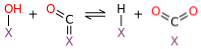

In [18]:
reaction_list1[76]

In [ ]:
r = ct.Reaction()


ct.InterfaceBlowersMaselRate()

In [67]:
data.keys()

dict_keys(['generator', 'input-files', 'cantera-version', 'date', 'units', 'phases', 'elements', 'species', 'gas-reactions', 'surface1-reactions'])

In [70]:
data['surface1-reactions'][40]

{'equation': 'CX(28) + CHOX(32) <=> COX(23) + CHX(27)',
 'rate-constant': {'A': 4.18e+21, 'b': 0.0, 'Ea': 11.654},
 'note': 'Reaction index: Chemkin #41; RMG #194\nTemplate reaction: Surface_Abstraction\nFlux pairs: CX(28), CHX(27); CHOX(32), COX(23);\nEstimated using template [C;*C-H] for rate rule [C$*;*-C-H]\nEuclidian distance = 1.4142135623730951\nfamily: Surface_Abstraction'}